In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# need this cell to import the help functions:

import os
path_sections = os.getcwd().split('\\')
if path_sections[-1] != 'CGM':
    os.chdir('./..')

In [28]:
# import help functions:

from data_processing.cgm_data import CGMData
from data_processing.cgm_data_helper import plot_series_with_food
from data_processing.derived_datasets import max_glucose_dataset,max_glucose_between_meals_dataset

from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor

In [6]:
data = CGMData()

In [7]:
# Finding 5/95th percentile idea from Dan Visscher

high_glu = []
low_glu = []

# Find 5th/95th percentile for glucose range for each patient
for i in range(1,3):
    low_glu.append(np.percentile(data[i].glu, 5))
    high_glu.append(np.percentile(data[i].glu, 95))




In [8]:
print(high_glu)
print(low_glu)

[137.0, 167.0]
[85.0, 99.0]


In [9]:
# participant_numbers = data.shape()
participant_numbers = 2

In [13]:
for pn in range(1,participant_numbers):
    # Select participant number
    participant_number = pn
    high_glu_par = high_glu[participant_number-1]

    # Max glucose between meals:
    df = max_glucose_dataset(cgm_data=data,participant_num=participant_number,glu_thresh=high_glu_par)
    df = pd.concat([df, pd.DataFrame(df)])

df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 40 entries, 0 to 19
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   calorie        40 non-null     float64
 1   total_carb     40 non-null     float64
 2   dietary_fiber  6 non-null      float64
 3   sugar          40 non-null     float64
 4   protein        40 non-null     float64
 5   total_fat      6 non-null      float64
 6   recent_meals   40 non-null     float64
 7   participant    40 non-null     int64  
 8   max_glucose    40 non-null     int64  
 9   high_glucose   40 non-null     bool   
dtypes: bool(1), float64(7), int64(2)
memory usage: 3.2 KB


In [20]:
## make the train test split here
## Note a slight difference, we have to use .copy()
## for pandas dataframes
df_train, df_test = train_test_split(df.copy(),
                                        random_state = 614,
                                        shuffle = True,
                                        test_size=.2) # this will leave out random meals from random participants

In [ ]:
plt.figure(figsize=(6,5))

plt.scatter(df_train['total_carb'], df_train['high_glucose'])

#plt.plot(np.linspace(0,120), log_reg.predict_proba(np.linspace(0,160).reshape(-1,1))[:,1], color = 'orange')
#plt.plot(np.linspace(7,13), my_log_reg.predict_proba(np.linspace(7,13).reshape(-1,1)), c = 'k')

plt.xlabel("total_carb", fontsize=12)
plt.ylabel("high_glucose", fontsize=12)
plt.show()

In [26]:
## Make a KFold object with k=5
kfold = KFold(5, shuffle = True, random_state = 440)

In [29]:
df_train[['total_carb']]

,total_carb
15,21.0
0,85.0
4,14.4
9,28.2
13,92.0
14,34.0
16,22.0
16,22.0
4,14.4
19,82.0


In [35]:
df_train.total_carb

15    21.0
0     85.0
4     14.4
9     28.2
13    92.0
14    34.0
16    22.0
16    22.0
4     14.4
19    82.0
11    35.0
7      3.4
6     37.2
19    82.0
5     69.0
3     30.0
1      2.5
3     30.0
17    96.0
1      2.5
8     33.0
18    35.0
11    35.0
12    30.4
2     35.0
9     28.2
10    70.0
15    21.0
13    92.0
5     69.0
8     33.0
7      3.4
Name: total_carb, dtype: float64

In [40]:
## make an array of zeros that will hold our mses
mses = np.zeros((2, 5))

## This keeps track of what split we are on
i = 0
## fill in what is missing in the for loop declaration
for i,(train_index, test_index) in enumerate(kfold.split(df_train)):
    ## now we get the training splits and the holdout split
    ### Training
    df_tt = df_train.iloc[train_index]
    
    ### Holdout set
    df_ho = df_train.iloc[test_index]
    
    
    ### This is Model 0 ###
    ## take the mean high_glucose from the training set
    ## we need predictions for the entire holdout set
    pred0 = df_tt.high_glucose.mean() * np.ones(len(df_ho))
    

    model1 = LogisticRegression()

    ## fit models on the training data, df_tt
    ## don't forget you may need to reshape the data for simple linear regressions
    model1.fit(df_tt.total_carb.values.reshape(-1,1), df_tt.high_glucose.values)
    
    
    ## get the prediction on holdout set
    pred1 = model1.predict(df_ho.total_carb.values.reshape(-1,1))
 
    
    ### Recording the MSES ###
    ## mean_squared_error takes in the true values, then the predicted values
    mses[0,i] = mean_squared_error(df_ho.high_glucose.values, pred0)
    mses[1,i] = mean_squared_error(df_ho.high_glucose.values, pred1)


In [41]:
mses

array([[0.20525714, 0.20525714, 0.22287968, 0.17110454, 0.30325444],
       [0.20321668, 0.20205073, 0.22023293, 0.17043414, 0.32072476]])

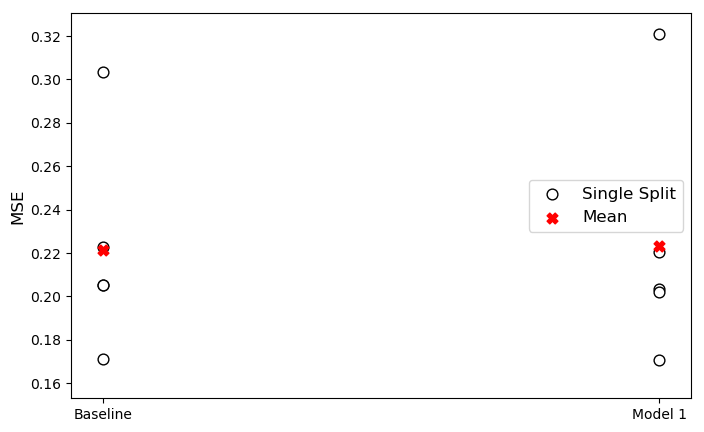

In [43]:
## This figure will compare the performance
plt.figure(figsize=(8,5))

plt.scatter(np.zeros(5), 
            mses[0,:], 
            s=60, 
            c='white',
            edgecolor='black',
            label="Single Split")
plt.scatter(np.ones(5), 
            mses[1,:], 
            s=60, 
            c='white',
            edgecolor='black')
plt.scatter([0,1], 
            np.mean(mses, axis=1), 
            s=60, 
            c='r',
            marker='X',
            label="Mean")

plt.legend(fontsize=12)

plt.xticks([0,1],["Baseline", "Model 1"], fontsize=10)
plt.yticks(fontsize=10)

plt.ylabel("MSE", fontsize=12)

plt.show()

In [16]:
X = df[['total_carb','sugar','protein']]
y = df[['high_glucose']]
y

,high_glucose
0,True
1,False
2,False
3,False
4,False
5,False
6,False
7,True
8,False
9,False


In [17]:
log_reg = LogisticRegression(penalty=None)
X = df[['total_carb']]
y = df['high_glucose']

## fit the model
log_reg.fit(X,y)

LogisticRegression(penalty=None)

In [18]:
log_reg.coef_[0][0]

0.0027966625550914196

next steps: 
1. put in data from all but the hold out participants
2. use first predictor project code to get baseline model predictions